In [1049]:
import pandas as pd
import numpy as np
import math
import sklearn.model_selection
import matplotlib.pyplot as plt

In [1050]:
#Load the house votes data file using python csv module
data = pd.read_csv('house_votes_84.csv')
dataCols = data.columns.tolist()

# houseVotesData: List to hold the iris data    
houseVotesData = data.to_numpy().astype(int)

In [1051]:
# Split the data into training and testing sets
# data: file data; ranNum: ensures reproducibilty; trainDt: resulting data set for training; testDt: resulting data set for testing 
def split_test_train(data, ranumber):
    # the training set will contain 80% of the data, the testing set will contain 20% of the data
    trainDt, testDt = sklearn.model_selection.train_test_split(data, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = ranumber)
    return trainDt.T, testDt.T

In [1052]:
# Descision Tree Class
class descisionTree:
    # used to store the label for the node
    label = None
    # used to store the type of node, such as a decision node/leaf node
    nodeType = ""
    # used to store the majority event label if the node is a leaf node
    majEvent = -1
    # used to store the name of the feature being tested
    testClass = ""
    # used to store a dictionary of child nodes
    nodeEdges = {}

    # intial instance 
    def __init__(self, label, nodeType):
        self.label = label
        self.nodeType = nodeType

In [1053]:
###############################################################################################################################################

# Descision Tree Helper Functions

# Takes a column of data as input and returns the entropy of the column
# column: the column of data being analyzed
def entropy(column):
    # initialize a dictionary to count the occurrences of each value in the input column
    cnts = {}
    for val in column:
        cnts[val] = cnts.get(val, 0) + 1
    # calculate entropy
    entropy = sum(-c / len(column) * math.log2(c / len(column)) for c in cnts.values())
    return entropy

# Calculates the Gini index of a given column using the formula
# column: the column of data being analyzed
def gini(column):
    # initialize a dictionary to count the occurrences of each value in the input column
    cnts = {}
    for val in column:
        cnts[val] = cnts.get(val, 0) + 1
    tCnt = len(column)
    # compute the gini impurity value
    giniIndexVal = 1 - sum((count / tCnt) ** 2 for count in cnts.values())
    return giniIndexVal

###############################################################################################################################################

# Testing criterias

# Calculates information gain (ID3)
# dataAttr: 2D array that represents the data, row contains data and column contains the attribute to the data instance; colAttr: names of columns in dataArr
def id3(dataAttr, colAttr):
    # entropy of the target variable
    trgtVar = dataAttr[-1]
    initEntropy = entropy(trgtVar)
    # variables for finding the best attribute
    minEntropy = float('inf')
    finalAtr = None
    # iterate over all attributes except the target variable
    for i, attr in enumerate(colAttr[:-1]):
        # extract unique values of the attribute
        attrVals = np.unique(dataAttr[i])
        # split the data based on the attribute
        attrData = [trgtVar[dataAttr[i] == value] for value in attrVals]
        # calculate entropy of the split data
        attrDataEntropy = sum(len(subset) / len(trgtVar) * entropy(subset) for subset in attrData)
        # update the best attribute if the split entropy is smaller
        if attrDataEntropy < minEntropy:
            minEntropy = attrDataEntropy
            finalAtr = attr
    # return the best attribute and the information gain
    infoGain = initEntropy - minEntropy
    return finalAtr, infoGain

# Calculates Split Gini Index (CART)
# dataAttr: 2D array that represents the data, row contains data and column contains the attribute to the data instance; colAttr: names of columns in dataArr
def cart(dataAttr, colAttr):
    # variables for finding the best attribute
    minGini = float('inf')
    finalAttr = None
    
    # iterate over all attributes except the target variable
    for attribute in colAttr[:-1]:
        # extract unique values of the attribute
        attrVals = set(dataAttr[colAttr.index(attribute)])
        giniVar = 0
        # split the data based on the attribute
        for value in attrVals:
            value_indices = [i for i in range(len(dataAttr[0])) if dataAttr[colAttr.index(attribute)][i] == value]
            value_labels = [dataAttr[-1][i] for i in value_indices]
            giniVar += len(value_labels) / len(dataAttr[-1]) * gini(value_labels)
        # update the best attribute if the split gini index is smaller
        if giniVar < minGini:
            minGini = giniVar
            finalAttr = attribute
    # return the best attribute and the gini index
    return finalAttr, minGini

# function returns the attribute to split the data and the corresponding metric value
# data: list containing data set; collAttr: list containing column attributes; algor: string indicating algorithm being used
def algorSplitAttr(data, colAttr, algor):
    return id3(data, colAttr) if algor == "id3" else cart(data, colAttr)
    
###############################################################################################################################################

In [1054]:

# Decision Tree  
     
def decisiontree(data, colAttr, algor):
    # initialize decision tree node
    node = descisionTree(label = -1, nodeType = "decision")
    # the value that occurs most frequently in that column
    vals, cnts = np.unique(data[-1], return_counts = True)
    # find the index of the most frequently occurring value in the counts array
    valIndex = np.argmax(cnts)
    # the value in the vals array at the same index as the most frequent value in the cnts array
    inpVals = vals[valIndex]

    node.majEvent = inpVals
    # check if all labels in data are same
    if len(set(data[-1])) == 1:
        # if true, create leaf node with the label
        node.nodeType, node.label = "leaf", data[-1][0]
        return node
    # check if there are no more attributes to split on
    elif not colAttr:
        # if true, create leaf node with majority event as label
        node.nodeType, node.label = "leaf", node.majEvent
        return node

    # find best attribute to split on using specified algorithm
    bestAttr = algorSplitAttr(data, colAttr, algor)[0]
    # set test class and index of best attribute
    node.testClass, bestAttrIdx = bestAttr, colAttr.index(bestAttr)
    # new list of attributes without best attribute
    colAttrSamp = colAttr[:bestAttrIdx] + colAttr[bestAttrIdx + 1:]

    # construct edges for the current node
    edge = {}
    for nVal in set(data[bestAttrIdx]):
        index = [idx for idx, e in enumerate(data[bestAttrIdx]) if e == nVal]
        # create subset of data for each value of best attribute
        subdata = np.delete(data.T[index].T, bestAttrIdx, axis=0)
        # check if subset is empty
        if subdata.size == 0:
            # if true, reate leaf node with majority event as label
            node.nodeType, node.label = "leaf", inpVals
            return node
        # recursively create subtree for subset
        subtree = decisiontree(subdata, colAttrSamp, algor)
        # add subtree to edge
        edge[nVal] = subtree
    # set edges of current node
    node.nodeEdges = edge
    
    return node

In [1055]:
# Prediction 

# returns a tuple that contains a boolean value indicating whether the prediction was correct or not, the predicted value, and the actual value
# tree: decision tree; instance: instance of data as input
def prediction(tree: descisionTree, instance):
    # initialize the predicted value to the majority event of the current node.
    predict = tree.majEvent
    # get the correct value from the last element of the instance.
    correct = instance[-1]
    # if the current node is a leaf node, return the predicted value and whether it matches the correct value.
    if tree.nodeType == 'leaf':
        predict = tree.label
        return predict == correct, predict, correct
    # if not, get the index of the test class for the current node.
    testindex = dataCols.index(tree.testClass)
    # check jf the value of the test class for the instance is not in the edges of the current node, return the predicted value and whether it matches the correct value.
    if instance[testindex] not in tree.nodeEdges:
        return predict == correct, predict, correct
    # Recursively call the function with the next tree node and the same instance of data.
    return prediction(tree.nodeEdges[instance[testindex]], instance)

# calculates the accuracy of a decision tree model on a given dataset
# data: string indicating whether to use train or test data; algorithm: string indicating the decision tree algorithm to use; ranNum: integer used for generating random splits
def accuracy(data, algorithm, ranNum):
    # calculate accuracy of a decision tree model on a given dataset
    def accuracyHelper(data, tree):
        return sum(prediction(tree, ins)[0] for ins in data.T) / len(data.T)
        
    accVals = []
    for i in range(1, 101):
        # split the data into training and test sets using a random seed
        housetrain, housetest = split_test_train(houseVotesData, 589 + ranNum * i)
        traintree = decisiontree(housetrain, dataCols, algorithm)
        # calculate the accuracy of the model on the specified data
        oc = accuracyHelper(housetrain, traintree) if data == 'train' else accuracyHelper(housetest, traintree) if data == 'test' else None
        accVals.append(oc)
    return accVals

The mean accuracy is 1.0, and the std is 0.0


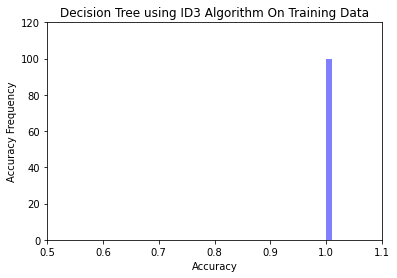

In [1056]:
# Q2.1 In the first histogram, you should show the accuracy distribution when the algorithm is evaluated over training data.
plotTrainID3 = np.array(accuracy('train', 'id3', 197))
# print(plotTrainID3)
print(f'The mean accuracy is {plotTrainID3.mean()}, and the std is {plotTrainID3.std()}')
plt.hist(plotTrainID3, density=1, bins=100, color='blue', alpha=0.5)
plt.axis([0.5, 1.1, 0, 120])
plt.title("Decision Tree using ID3 Algorithm On Training Data")
plt.ylabel("Accuracy Frequency")
plt.xlabel("Accuracy")
plt.show()

The mean accuracy is 0.9383908045977009, and the std is 0.023863796362962722


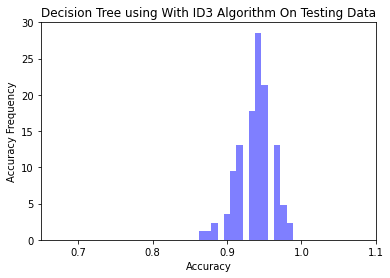

In [1057]:
# Q2.2 In the second histogram, you should show the accuracy distribution when the algorithm is evaluated over testing data.
plotTestID3 = np.array(accuracy('test', 'id3', 197))
# print(plotTestID3)
print(f'The mean accuracy is {plotTestID3.mean()}, and the std is {plotTestID3.std()}')
plt.hist(plotTestID3, density=1, bins=15, color='blue', alpha=0.5)
plt.axis([0.65, 1.1, 0, 30])
plt.title("Decision Tree using With ID3 Algorithm On Testing Data")
plt.ylabel("Accuracy Frequency")
plt.xlabel("Accuracy")
plt.show()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
The mean accuracy is 1.0, and the std is 0.0


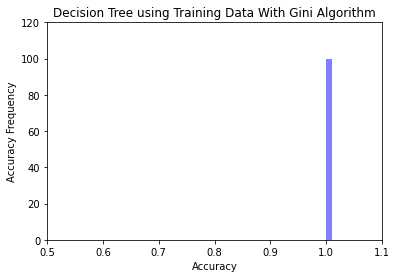

In [1058]:
# QE.1 Repeat the experiments Q2.1 to Q2.4, but now use the Gini criterion for node splitting, instead of the Information Gain criterion.

plotTrainGini = np.array(accuracy('train', 'cart', 197))
# print(plotTrainGini)
print(f'The mean accuracy is {plotTrainGini.mean()}, and the std is {plotTrainGini.std()}')
plt.hist(plotTrainGini, density=1, bins=100, color='blue', alpha=0.5)
plt.title("Decision Tree using Training Data With Gini Algorithm")
plt.axis([0.5, 1.1, 0, 120])
plt.ylabel("Accuracy Frequency")
plt.xlabel("Accuracy")
plt.show()

[0.96551724 0.94252874 0.95402299 0.94252874 0.94252874 0.96551724
 0.95402299 0.94252874 0.91954023 0.94252874 0.93103448 0.94252874
 0.94252874 0.93103448 0.97701149 0.96551724 0.96551724 0.93103448
 0.94252874 0.93103448 0.97701149 0.97701149 0.91954023 0.90804598
 0.98850575 0.97701149 0.95402299 0.90804598 0.91954023 0.96551724
 0.94252874 0.93103448 0.95402299 0.96551724 0.96551724 0.94252874
 0.94252874 0.88505747 0.94252874 0.90804598 0.95402299 0.91954023
 0.88505747 0.94252874 0.88505747 0.91954023 0.93103448 0.89655172
 0.94252874 0.93103448 0.95402299 0.90804598 0.95402299 0.91954023
 0.94252874 0.91954023 0.91954023 0.95402299 0.90804598 0.90804598
 0.93103448 0.88505747 0.86206897 0.95402299 0.89655172 0.95402299
 0.94252874 0.95402299 0.96551724 0.93103448 0.93103448 0.91954023
 0.94252874 0.95402299 0.96551724 0.96551724 0.95402299 0.94252874
 0.96551724 0.95402299 0.95402299 0.95402299 0.97701149 0.95402299
 0.94252874 0.94252874 0.95402299 0.93103448 0.93103448 0.9540

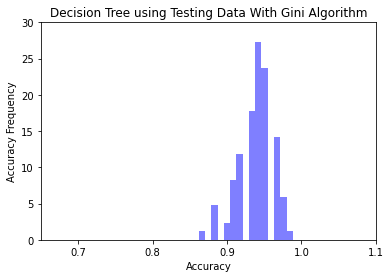

In [1059]:
# QE.1 Repeat the experiments Q2.1 to Q2.4, but now use the Gini criterion for node splitting, instead of the Information Gain criterion.
plotTestGini = np.array(accuracy('test', 'cart', 197))
# print(plotTestGini)
print(f'The mean accuracy is {plotTestGini.mean()}, and the std is {plotTestGini.std()}')
plt.hist(plotTestGini, density=1, bins=15, color='blue', alpha=0.5)
plt.axis([0.65, 1.1, 0, 30])
plt.title("Decision Tree using Testing Data With Gini Algorithm")
plt.ylabel("Accuracy Frequency")
plt.xlabel("Accuracy")
plt.show()